In [2]:
# Core imports and lightweight VoidX import
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import json
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, precision_score, recall_score, roc_auc_score
from sklearn.calibration import calibration_curve
from voidx_voronoi.data import *
from voidx_voronoi.ml_loader import *
from voidx_voronoi.config import get_config


# Enable LaTeX for text rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14  # Adjust font size

# Configuration

In [3]:
config = get_config(name='test_data')  # picks up everything from config/global.json

# For backward compatibility, create variables from config
name = config.name
model_name = config.model_name
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
seed = config.seed
use_periodic_boundaries = True  # if True, compute distances with PBC (minimal image)

# Paths are automatically set up
data_dir = config.data_dir
galaxy_info_dir = config.galaxy_info_dir
checkpoint_dir_spec = config.checkpoint_dir_spec
checkpoint_dir_global = config.checkpoint_dir_global
plot_dir = config.plot_dir
result_dir = config.result_dir

config.print_info()


Loading global settings from /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/config/config_global.json
Using device: mps
Notebook Configuration
Dataset: test_data
Model name: test_data_
Device: mps, Seed: 42
------------------------------------------------------------
Paths:
  data_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/test_data
  galaxy_info_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/test_data/galaxy_info_files
  checkpoint_dir_spec: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/test_data/checkpoints
  checkpoint_dir_global: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/checkpoints
  plot_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/test_data/plot
  result_dir: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX_voronoi/data/test_data/result


# Reproducibility

In [ ]:
# Load previously saved minimal Voronoi features for ML
path = galaxy_info_dir / "galaxy_subset_voronoi.npz"
with np.load(path, allow_pickle=True) as saved:
    coords = saved["points"]            # (N, 3) site coordinates
    volumes = saved["volumes"]          # (N,) cell volumes (nan for unbounded/clipped)
    indptr = saved["indptr"]            # CSR pointers
    indices = saved["indices"]          # CSR indices (neighbors)
    finite_mask = saved["finite_mask"]   # (N,) boolean mask

# Build edge_index (2, E) for graph ML
edge_index = build_edge_index_from_csr(indptr, indices)

print(f"coords: {coords.shape} | volumes: {volumes.shape} | edge_index: {edge_index.shape}")
print(f"finite cells: {int(finite_mask.sum())} / {coords.shape[0]}")

# Optional: convert to PyTorch tensors for ML dataloaders
try:
    import torch
    x = torch.from_numpy(coords).float()            # node features (here: coordinates)
    vol = torch.from_numpy(volumes).float()         # per-node volume (may contain NaN for unbounded)
    edge_index_t = torch.from_numpy(edge_index).long()
    finite_mask_t = torch.from_numpy(finite_mask)
    print("Torch tensors -> x:", x.shape, "vol:", vol.shape, "edge_index:", edge_index_t.shape)
except Exception as e:
    print("Torch not available or failed to import:", e)

# Split the data into training, validation, and test sets

In [23]:
train_idx, val_idx, test_idx = split_indices(len(X), train=0.7, val=0.15, seed=seed)
print("Train/Val/Test sizes:", len(train_idx)/len(X), len(val_idx)/len(X), len(test_idx)/len(X))
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]
print("Train X shape:", X_train.shape, "y shape:", y_train.shape)
print("Val   X shape:", X_val.shape, "y shape:", y_val.shape)
print("Test  X shape:", X_test.shape, "y shape:", y_test.shape)

Train/Val/Test sizes: 0.7 0.15 0.15
Train X shape: (8400, 400) y shape: (8400,)
Val   X shape: (1800, 400) y shape: (1800,)
Test  X shape: (1800, 400) y shape: (1800,)


# Normalize features using train stats

In [24]:
mean = X_train.mean(axis=0, keepdims=True)
std = X_train.std(axis=0, keepdims=True) + 1e-6
std[std == 0] = 1.0  # avoid division by zero

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

# Dataset and DataLoader

In [25]:
batch_size = 128
ds_train = GalaxyDataset(X_train, y_train)
ds_val = GalaxyDataset(X_val, y_val)
ds_test = GalaxyDataset(X_test, y_test)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=0)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=0)

# Model definition

In [26]:
in_dim = X_train.shape[1]
model = MLP(in_dim=in_dim, hidden=(256,128,64), dropout=0.3).to(device)
n_params = sum(p.numel() for p in model.parameters()) 
print(model)
print(f"Parameters: {n_params:,}")

MLP(
  (net): Sequential(
    (0): Linear(in_features=400, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)
Parameters: 143,873


# Class imbalance handling

In [27]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
print(f"Train set: {pos} positives, {neg} negatives, ratio={pos/neg:.4f}")
pos_weight = torch.tensor(neg / max(pos, 1), dtype=torch.float32).to(device)
print(f"Using pos_weight={pos_weight:.4f} for BCEWithLogitsLoss")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Train set: 1368 positives, 7032 negatives, ratio=0.1945
Using pos_weight=5.1404 for BCEWithLogitsLoss


# Train with early stopping

In [28]:
def train_MLP(
    model,
    dl_train,
    dl_val,
    ds_train,
    ds_val,
    optimizer,
    criterion,
    scheduler,
    device,
    model_name,
    checkpoint_dir_global,
    checkpoint_dir_spec=None,
    num_epochs=10,
    patience=7,
    resume=False,
    verbose=True,
):
    history = {'train_loss': [], 'val_loss': [], 'precision': [], 'recall': [], 'auc': []}
    best_val = float('inf')
    best_state = None
    no_improve = 0

    ckpt_path = checkpoint_dir_global / f'best_model_{model_name}.pth'
    ckpt_path.parent.mkdir(parents=True, exist_ok=True)
    if verbose:
        print("Checkpoint path:", ckpt_path)

    if resume and ckpt_path.exists():
        if verbose:
            print("Loading checkpoint:", ckpt_path)
        state = torch.load(ckpt_path, map_location=device)
        model.load_state_dict(state)

    start_time = time.time()
    for epoch in range(1, num_epochs + 1):
        epoch_start = time.time()
        model.train()
        running = 0.0

        pbar = tqdm(dl_train, desc=f"Epoch {epoch:03d}/{num_epochs} [train]", leave=False)
        for xb, yb in pbar:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running += loss.item() * xb.size(0)
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        train_loss = running / len(ds_train)

        model.eval()
        v_running = 0.0
        all_logits, all_targets = [], []
        with torch.no_grad():
            pbar_val = tqdm(dl_val, desc=f"Epoch {epoch:03d}/{num_epochs} [val]  ", leave=False)
            for xb, yb in pbar_val:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                v_running += loss.item() * xb.size(0)
                all_logits.append(logits.cpu())
                all_targets.append(yb.cpu())
        val_loss = v_running / len(ds_val)

        logits_np = torch.cat(all_logits).numpy().ravel()
        targets_np = torch.cat(all_targets).numpy().ravel()
        probs = 1 / (1 + np.exp(-logits_np))
        preds = (probs >= 0.5).astype(np.int32)
        precision = precision_score(targets_np, preds, zero_division=0)
        recall = recall_score(targets_np, preds, zero_division=0)
        auc = roc_auc_score(targets_np, probs)

        if scheduler is not None:
            scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['auc'].append(auc)

        current_lr = optimizer.param_groups[0]['lr']
        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(best_state, ckpt_path)
            if checkpoint_dir_spec is not None:
                (checkpoint_dir_spec).mkdir(parents=True, exist_ok=True)
                torch.save(best_state, checkpoint_dir_spec / f'best_model_{model_name}.pth')
            no_improve = 0
            improved = "*"
        else:
            no_improve += 1
            improved = ""

        epoch_time = time.time() - epoch_start
        total_time = time.time() - start_time

        if verbose:
            print(
                f"Epoch {epoch:03d}/{num_epochs} | "
                f"train {train_loss:.4f} | val {val_loss:.4f}{improved} | "
                f"prec {precision:.4f} | rec {recall:.4f} | auc {auc:.4f} | "
                f"lr {current_lr:.2e} | "
                f"no_improve {no_improve}/{patience} | "
                f"epoch {epoch_time:.1f}s | total {total_time/60:.1f}min"
            )

        if no_improve >= patience:
            if verbose:
                print("Early stopping")
            break

    return history, best_state, best_val

ckpt_path = checkpoint_dir_global / f'best_model_{model_name}.pth'
history, best_state, best_val = train_MLP(
    model,
    dl_train,
    dl_val,
    ds_train,
    ds_val,
    optimizer,
    criterion,
    scheduler,
    device,
    model_name=model_name,
    checkpoint_dir_global=checkpoint_dir_global,
    checkpoint_dir_spec=checkpoint_dir_spec,
    num_epochs=30,
    patience=7,
    resume=False,
    verbose=True,
)

Checkpoint path: /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/checkpoints/best_model_synthetic_void_0.5.pth


Epoch 001/30 | train 0.7276 | val 0.6987* | prec 0.5253 | rec 0.8006 | auc 0.9031 | lr 1.00e-03 | no_improve 0/7 | epoch 1.2s | total 0.0min


Epoch 002/30 | train 0.5933 | val 0.6401* | prec 0.5861 | rec 0.7878 | auc 0.9175 | lr 1.00e-03 | no_improve 0/7 | epoch 0.6s | total 0.0min


Epoch 003/30 | train 0.5416 | val 0.6225* | prec 0.5791 | rec 0.8006 | auc 0.9196 | lr 1.00e-03 | no_improve 0/7 | epoch 0.7s | total 0.0min


Epoch 004/30 | train 0.4932 | val 0.6220* | prec 0.6015 | rec 0.7910 | auc 0.9240 | lr 1.00e-03 | no_improve 0/7 | epoch 0.6s | total 0.1min


Epoch 005/30 | train 0.4654 | val 0.6137* | prec 0.6173 | rec 0.7781 | auc 0.9255 | lr 1.00e-03 | no_improve 0/7 | epoch 0.6s | total 0.1min


Epoch 006/30 | train 0.4330 | val 0.6287 | prec 0.6371 | rec 0.7846 | auc 0.9266 | lr 1.00e-03 | no_improve 1/7 | epoch 0.6s | total 0.1min


Epoch 007/30 | train 0.3958 | val 0.6225 | prec 0.6159 | rec 0.8199 | auc 0.9281 | lr 1.00e-03 | no_improve 2/7 | epoch 0.5s | total 0.1min


Epoch 008/30 | train 0.3851 | val 0.6558 | prec 0.6481 | rec 0.7878 | auc 0.9318 | lr 1.00e-03 | no_improve 3/7 | epoch 0.6s | total 0.1min


Epoch 009/30 | train 0.3404 | val 0.6310 | prec 0.6208 | rec 0.8264 | auc 0.9314 | lr 5.00e-04 | no_improve 4/7 | epoch 0.5s | total 0.1min


Epoch 010/30 | train 0.3196 | val 0.6397 | prec 0.6167 | rec 0.8071 | auc 0.9298 | lr 5.00e-04 | no_improve 5/7 | epoch 0.5s | total 0.1min


Epoch 011/30 | train 0.2761 | val 0.7026 | prec 0.6750 | rec 0.7814 | auc 0.9341 | lr 5.00e-04 | no_improve 6/7 | epoch 0.5s | total 0.1min


Epoch 012/30 | train 0.2544 | val 0.6916 | prec 0.6320 | rec 0.8006 | auc 0.9324 | lr 5.00e-04 | no_improve 7/7 | epoch 0.5s | total 0.1min
Early stopping


# Load best model

In [29]:
if best_state is None and ckpt_path.exists():
    print("Loading best model from checkpoint")
    best_state = torch.load(ckpt_path, map_location='cpu')
    if best_state is not None:
        print("Loaded best model from checkpoint")
        model.load_state_dict(best_state)
        model.to(device)

# Plot training curves

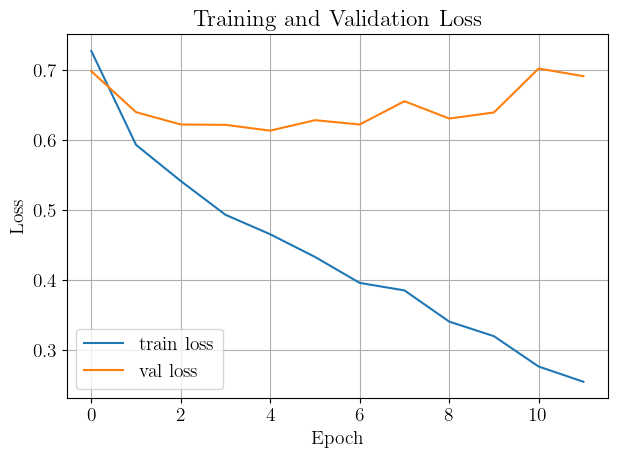

In [30]:
# Plot training history across all
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [31]:
# Derive threshold on validation by maximizing TSS, then apply on test
val_metrics = evaluate_model(model, dl_val, device=device)
fpr_v, tpr_v, thr_v = roc_curve(val_metrics['targets'], val_metrics['probs'])
tss_v = tpr_v - fpr_v
best_idx = int(np.argmax(tss_v)) if len(tss_v) else 0
best_thr = thr_v[best_idx] if len(thr_v) else 0.5
print(f"Selected threshold from validation (max TSS): {best_thr:.4f} | TSS_val_max={tss_v[best_idx]:.4f}")

# Evaluate test at fixed threshold
test_probs = evaluate_model(model, dl_test, device=device)['probs']
test_preds_thr = (test_probs >= best_thr).astype(int)
test_targets = evaluate_model(model, dl_test, device=device)['targets']
cm_thr = confusion_matrix(test_targets, test_preds_thr, labels=[0,1])
tn, fp, fn, tp = cm_thr.ravel() if cm_thr.size==4 else (0,0,0,0)
tpr = tp / (tp + fn) if (tp+fn)>0 else 0.0
fpr = fp / (fp + tn) if (fp+tn)>0 else 0.0
tss_fixed = tpr - fpr
bal_acc_fixed = ( (tp/(tp+fn) if (tp+fn)>0 else 0) + (tn/(tn+fp) if (tn+fp)>0 else 0) ) / 2.0
mcc_num = (tp*tn - fp*fn)
mcc_den = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
mcc_fixed = (mcc_num / mcc_den) if mcc_den>0 else 0.0
print(f"Fixed-threshold@valTSS | thr={best_thr:.4f} | TPR={tpr:.3f} | FPR={fpr:.3f} | TSS={tss_fixed:.3f} | BalAcc={bal_acc_fixed:.3f} | MCC={mcc_fixed:.3f}")

Selected threshold from validation (max TSS): 0.3025 | TSS_val_max=0.7298
Fixed-threshold@valTSS | thr=0.3025 | TPR=0.838 | FPR=0.119 | TSS=0.719 | BalAcc=0.860 | MCC=0.638


# Evaluate on test set

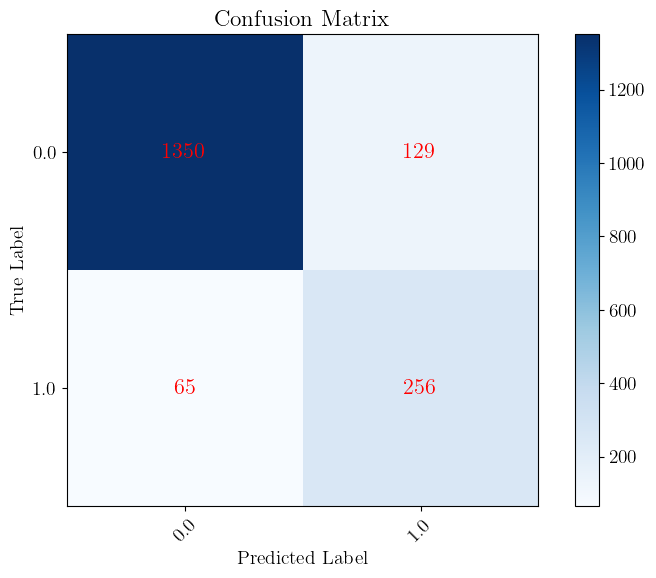

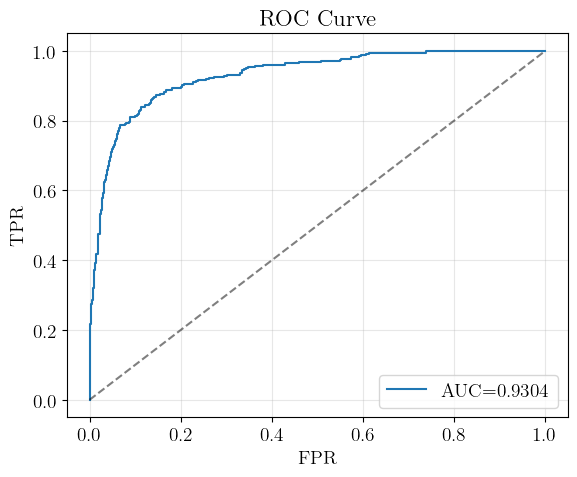

In [32]:
test_metrics = evaluate_model(model, dl_test, device=device)
# Compute class labels and confusion matrix
# Derive class labels from the targets and predictions, ensuring deterministic label order
class_labels = np.unique(np.concatenate((test_metrics['targets'], test_metrics['preds'])))

# Compute the confusion matrix
cm = confusion_matrix(test_metrics['targets'], test_metrics['preds'], labels=class_labels)
cmap = plt.cm.Blues

# Display the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Confusion Matrix')
plt.colorbar()

# Add class labels to the axes
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Annotate the matrix cells with values
for i in range(2): 
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red', fontsize=16)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, thr = roc_curve(test_metrics['targets'], test_metrics['probs'])
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={test_metrics['roc_auc']:.4f}")
plt.plot([0,1],[0,1],'k--',alpha=0.5) 
plt.xlabel('FPR')
plt.ylabel('TPR') 
plt.title('ROC Curve') 
plt.grid(True, alpha=0.3) 
plt.legend() 
plt.tight_layout() 
plt.show()


In [33]:
# Print robust, prior-insensitive metrics
print(
    " | ".join([
        f"AUC: {test_metrics['roc_auc']:.4f}",
        f"BalancedAcc: {test_metrics['balanced_accuracy']:.4f}",
        f"MCC: {test_metrics['mcc']:.4f}",
        f"TSSmax: {test_metrics['tss_max']:.4f}",
        f"BrierSkill: {test_metrics['brier_skill']:.4f}",
        f"LogLossSkill: {test_metrics['log_loss_skill']:.4f}"
    ])
)

AUC: 0.9304 | BalancedAcc: 0.8551 | MCC: 0.6631 | TSSmax: 0.7285 | BrierSkill: 0.4262 | LogLossSkill: 0.3360


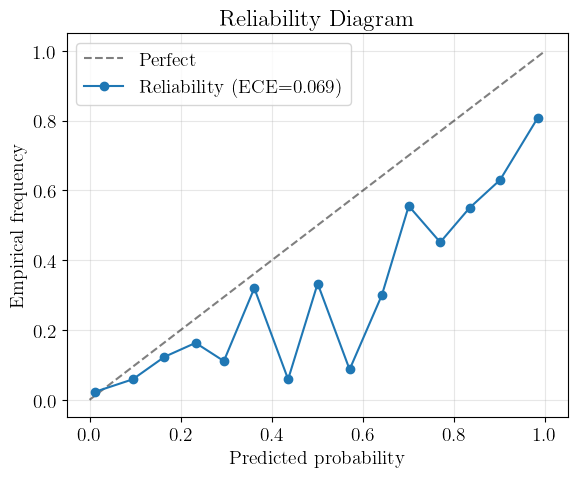

In [34]:
# Reliability diagram (calibration) and ECE
def expected_calibration_error(y_true, y_prob, n_bins=15):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    # Compute binning to measure ECE
    bins = np.linspace(0.0, 1.0, n_bins+1)
    inds = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = inds == b
        if np.any(mask):
            acc_b = y_true[mask].mean()
            conf_b = y_prob[mask].mean()
            w_b = mask.mean()
            ece += w_b * abs(acc_b - conf_b)
    return ece, prob_true, prob_pred

ece, prob_true, prob_pred = expected_calibration_error(test_metrics['targets'], test_metrics['probs'], n_bins=15)
plt.figure(figsize=(6,5))
plt.plot([0,1], [0,1], 'k--', alpha=0.5, label='Perfect')
plt.plot(prob_pred, prob_true, marker='o', label=f'Reliability (ECE={ece:.3f})')
plt.xlabel('Predicted probability')
plt.ylabel('Empirical frequency')
plt.title('Reliability Diagram')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

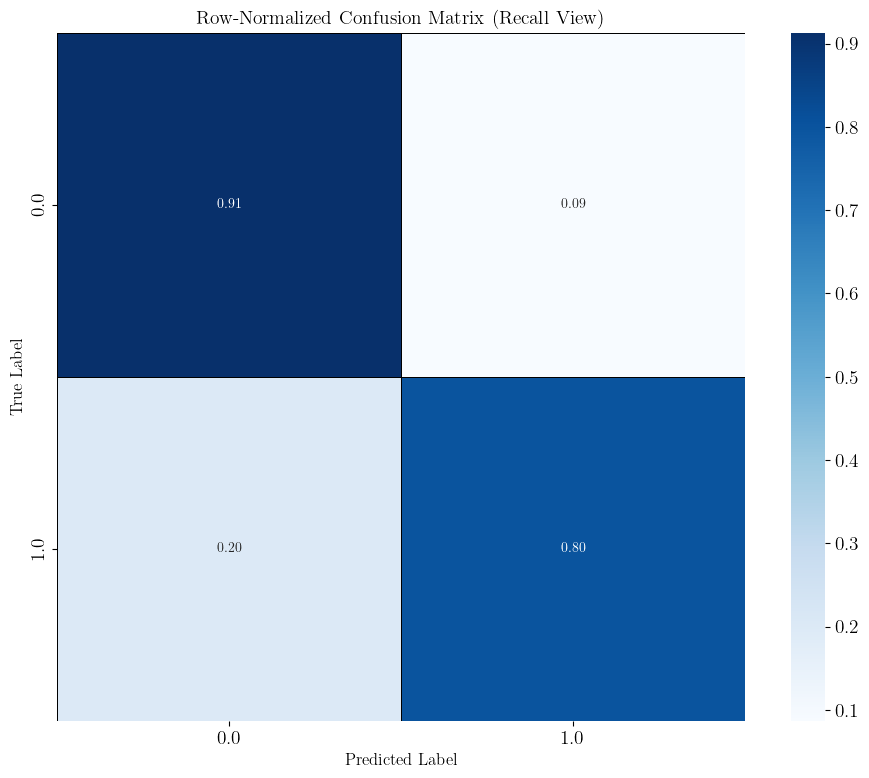

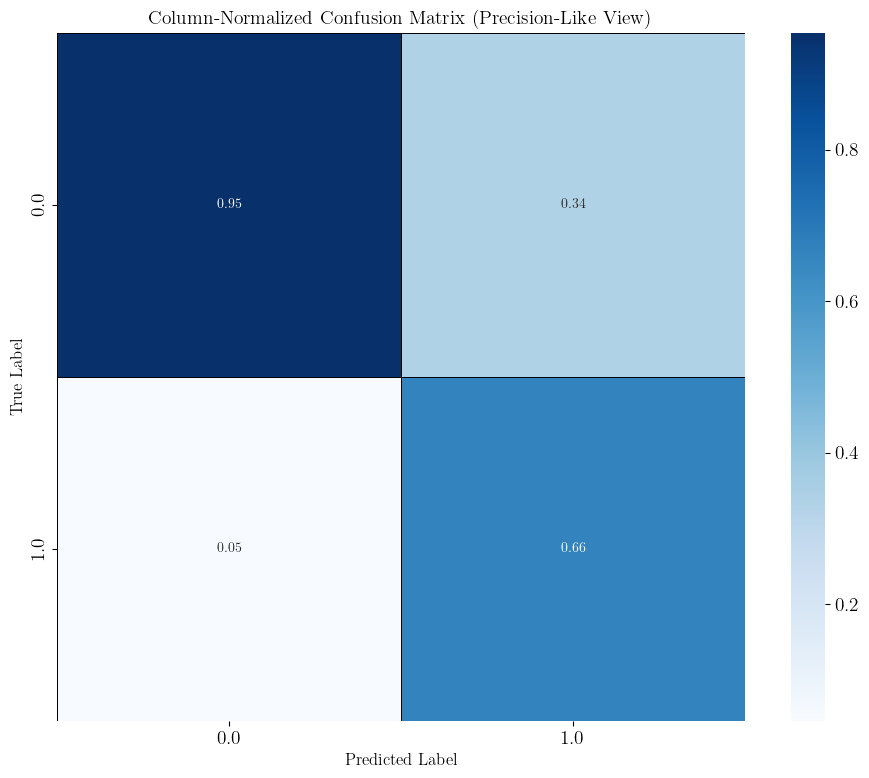

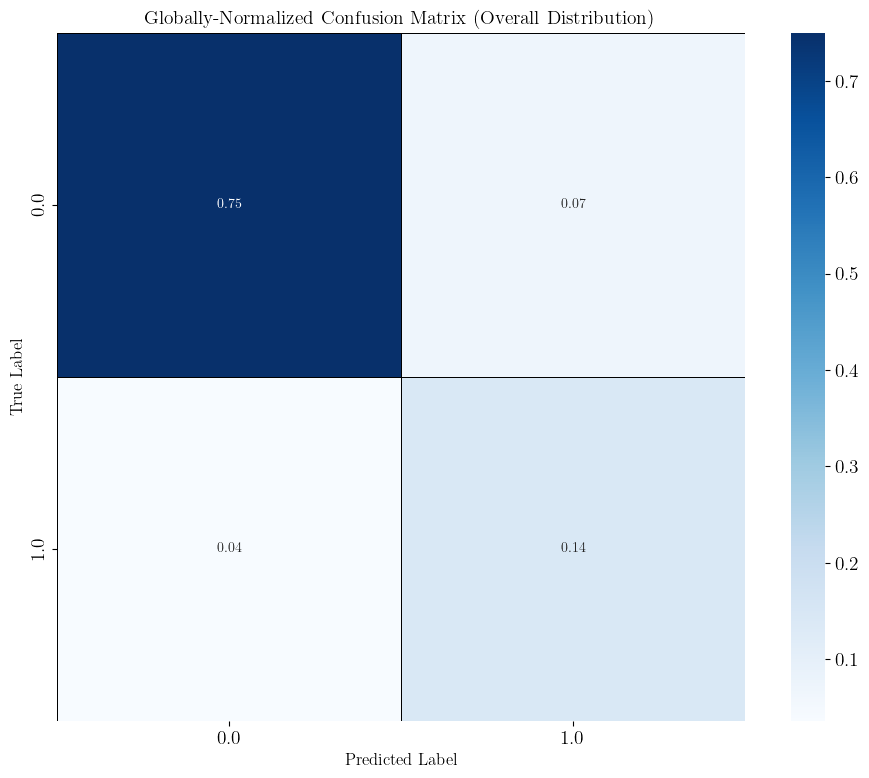

In [35]:
# Row-normalized confusion matrix (recall view)
row_normalized_cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
row_normalized_cm[np.isnan(row_normalized_cm)] = 0  # Handle division by zero

plt.figure(figsize=(10, 8))
sns.heatmap(
    row_normalized_cm,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels,
    linewidths=0.5,
    linecolor="black",
    square=True,
    annot_kws={"fontsize": 10},
)
plt.title("Row-Normalized Confusion Matrix (Recall View)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

# Column-normalized confusion matrix (precision-like view)
col_normalized_cm = cm.astype('float') / cm.sum(axis=0, keepdims=True)
col_normalized_cm[np.isnan(col_normalized_cm)] = 0  # Handle division by zero

plt.figure(figsize=(10, 8))
sns.heatmap(
    col_normalized_cm,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels,
    linewidths=0.5,
    linecolor="black",
    square=True,
    annot_kws={"fontsize": 10},
)
plt.title("Column-Normalized Confusion Matrix (Precision-Like View)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

# Globally-normalized confusion matrix (overall distribution)
global_normalized_cm = cm.astype('float') / cm.sum()
global_normalized_cm[np.isnan(global_normalized_cm)] = 0  # Handle division by zero

plt.figure(figsize=(10, 8))
sns.heatmap(
    global_normalized_cm,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels,
    linewidths=0.5,
    linecolor="black",
    square=True,
    annot_kws={"fontsize": 10},
)
plt.title("Globally-Normalized Confusion Matrix (Overall Distribution)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

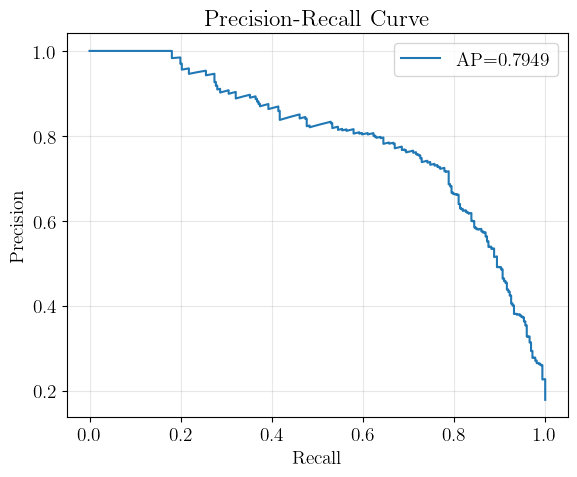

In [36]:
# Precision-Recall curve and Average Precision (AP)
prec, rec, thr_pr = precision_recall_curve(test_metrics['targets'], test_metrics['probs'])
ap = average_precision_score(test_metrics['targets'], test_metrics['probs'])
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f'AP={ap:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Save key metrics to JSON for later comparison
metrics_to_save = {
    'auc': float(test_metrics['roc_auc']),
    'balanced_accuracy': float(test_metrics['balanced_accuracy']),
    'mcc': float(test_metrics['mcc']),
    'tss_max': float(test_metrics['tss_max']),
    'brier_skill': float(test_metrics['brier_skill']),
    'log_loss_skill': float(test_metrics['log_loss_skill']),
    'val_tss_threshold': float(best_thr),
    'fixed_thr_tss': float(tss_fixed),
    'fixed_thr_bal_acc': float(bal_acc_fixed),
    'fixed_thr_mcc': float(mcc_fixed),
    # 'ap': float(ap),
    'ece': float(ece),
}

metrics_path = result_dir / f'metrics_{model_name}.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics_to_save, f, indent=2)
print(f'Saved metrics to {metrics_path}')

Saved metrics to /Users/boccardpierre/Documents/PhD/Research/Code/VoidX/data/synthetic_void/result/metrics_synthetic_void_0.5.json


In [38]:
# Sanity check: single batch forward pass
xb, yb = next(iter(dl_train))
xb = xb.to(device)
yb = yb.to(device)
with torch.no_grad():
    logits = model(xb)
    loss_val = criterion(logits, yb).item()
print("Single batch logits shape:", logits.shape)
print("Single batch loss:", loss_val)

Single batch logits shape: torch.Size([128])
Single batch loss: 0.24007749557495117
